In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/smoking/Training/Training'
test_path = '/kaggle/input/smoking/Testing/Testing'
valid_path = '/kaggle/input/smoking/Validation/Validation'

In [3]:
def extract_from_path(path)-> []:
    full_path = []
    for i in sorted(os.listdir(path)):
        full_path.append(os.path.join(path, i))
    return full_path

In [4]:
train_images = extract_from_path(train_path)
test_images = extract_from_path(test_path)
valid_images = extract_from_path(valid_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of test_images is {len(test_images)}")
print(f"The length of valid_images is {len(valid_images)}")

The length of train_images is 716
The length of test_images is 224
The length of valid_images is 180


In [5]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-1].split('_')[0] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'smoking' else 0)
    return df

In [6]:
train_images_df = createDataFrame(train_images)
test_images_df = createDataFrame(test_images)
valid_images_df = createDataFrame(valid_images)

In [7]:
def plotCount(df):
    name = df["path"][0].split("/")[4]
    smoking = df[df['label_id'] == 1]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total smoking images is {len(smoking)}")
    print(f"Total non-smoking images is {len(df)-len(smoking)}")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)

Total images in Training is 716
Total smoking images is 358
Total non-smoking images is 358


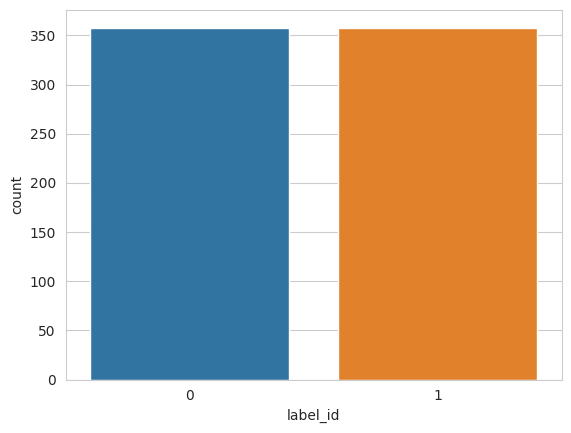

In [8]:
plotCount(train_images_df)

Total images in Testing is 224
Total smoking images is 112
Total non-smoking images is 112


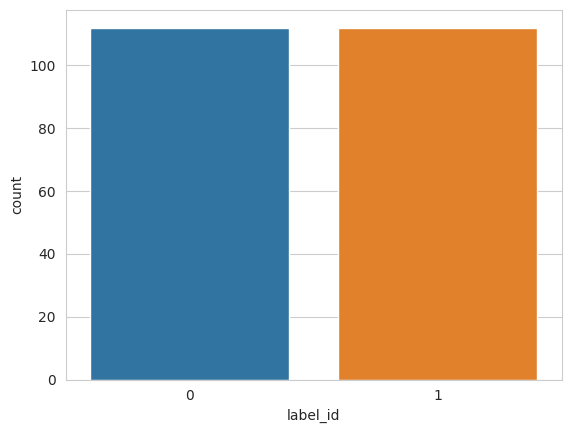

In [9]:
plotCount(test_images_df)

Total images in Validation is 180
Total smoking images is 90
Total non-smoking images is 90


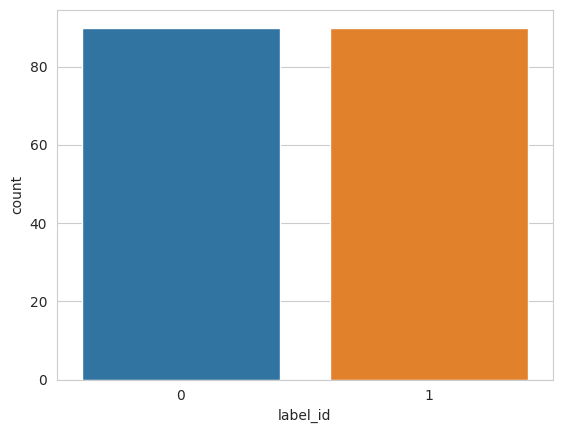

In [10]:
plotCount(valid_images_df)

#### The data set is balanced. It has exactly the same no of images per class in all the three divisions

#### 👨‍🔧  Pre-processing

In [11]:
train_images_df

,path,label,label_id
0,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
1,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
2,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
3,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
4,/kaggle/input/smoking/Training/Training/notsmo...,notsmoking,0
...,...,...,...
711,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
712,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
713,/kaggle/input/smoking/Training/Training/smokin...,smoking,1
714,/kaggle/input/smoking/Training/Training/smokin...,smoking,1


In [12]:
import tensorflow as tf

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

def imgPreProcessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMAGE_SIZE))
    return img, label
def loadDataset(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE))
                

In [13]:
train_data = loadDataset(train_images_df)
test_data = loadDataset(test_images_df)
valid_data = loadDataset(valid_images_df)

In [14]:
# Visualize some random images from the training data

def plotRandom(data):
    for img,label in data.take(1):
        randomNum = random.randint(0, BATCH_SIZE - 1)
        text_label = "Smoking" if label[randomNum].numpy() == 1 else "Non-Smoking"
        plt.figure(figsize=(4, 4))
        plt.imshow(img[randomNum]/255.)
        plt.title(text_label)
        plt.axis('off') 
        plt.show()

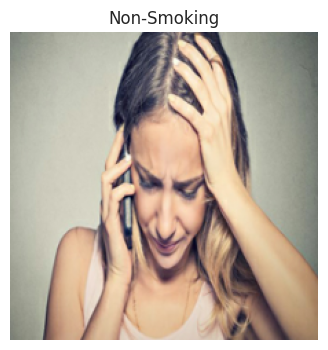

In [15]:
plotRandom(train_data)

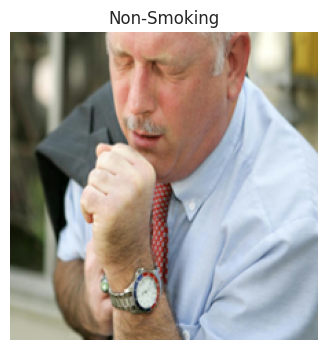

In [16]:
plotRandom(train_data)

##### Fitting a baseline model on the dataset (EfficientNetB0)

In [17]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [18]:
def plot_history(model_history):
    plt.style.use("seaborn-v0_8-whitegrid")
    df = pd.DataFrame(model_history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    loss = df['loss']
    accuracy = df['accuracy']
    val_loss = df['val_loss']
    val_accuracy = df['val_accuracy']
    epochs = range(len(df['val_loss']))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title("Loss")
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.set_title("Accuracy")
    
    # Adjust spacing and titles
    plt.tight_layout()
    plt.show()

In [19]:
base_eff0 = create_b0_base()
# fit the model
base_eff0_history = base_eff0.fit(train_data,epochs = 5, steps_per_epoch = len(train_data),validation_data = valid_data, validation_steps = len(valid_data))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5


2023-12-19 09:54:52.200141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 21s 226ms/step - loss: 0.5412 - accuracy: 0.7346 - val_loss: 0.3116 - val_accuracy: 0.8889
Epoch 2/5
23/23 [==============================] - 2s 67ms/step - loss: 0.3756 - accuracy: 0.8506 - val_loss: 0.2587 - val_accuracy: 0.8944
Epoch 3/5
23/23 [==============================] - 2s 66ms/step - loss: 0.3108 - accuracy: 0.8841 - val_loss: 0.2152 - val_accuracy: 0.9167
Epoch 4/5
23/23 [==============================] - 2s 67ms/step - loss: 0.2798 - accuracy: 0.8980 - val_loss: 0.2131 - val_accuracy: 0.9111
Epoch 5/5
23/23 [==============================] - 2s 66ms/step - loss: 0.2742 - accuracy: 0.8966 - val_loss: 0.2186 - val_accuracy: 0.9167


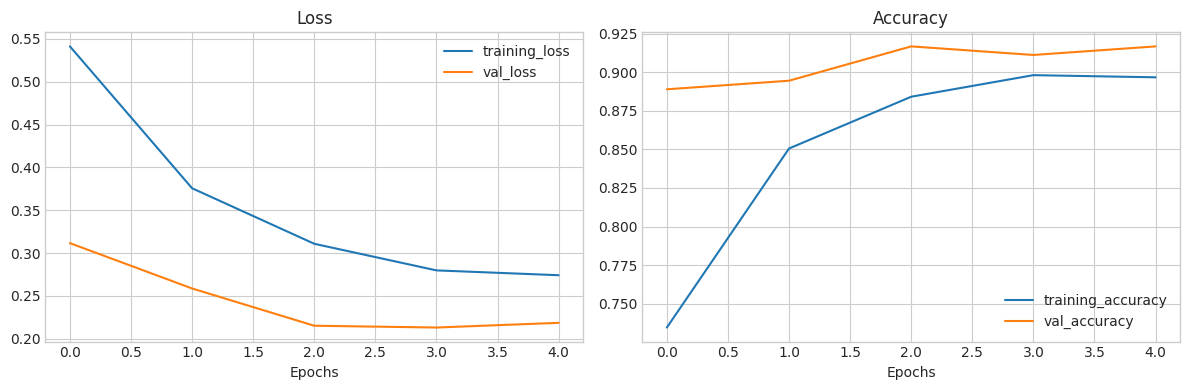

In [20]:
plot_history(base_eff0_history)

In [21]:
base_eff0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 5921874 (22.59 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


#### ⚡️ Data Augmentaion

In [22]:
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_brightness(img, 0.1,seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.5,seed = SEED)
    img = tf.image.random_saturation(img, .5, 1,seed = SEED)
    img = tf.image.random_hue(img, 0.2,seed = SEED)
    return img, label

def loadDatasetWithAugmentaion(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                 .map(augmentation)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE)
           )

In [23]:
# Loading only 25 % for data augmentaion
data_size = len(train_images_df)
train_data_aug_20 = loadDatasetWithAugmentaion(train_images_df.sample(frac=1)[:int(0.25 * data_size)])

Visulize the augmented images

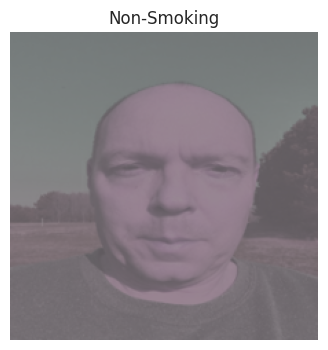

In [24]:
plotRandom(train_data_aug_20)

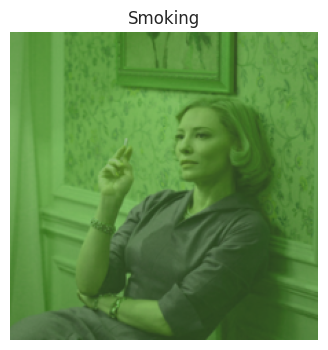

In [25]:
plotRandom(train_data_aug_20)

In [26]:
# create a checkpoint callback to save the model
checkpoint_path = "25_percent_augmented/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [27]:
base_eff_modelOne = create_b0_base()
initial_epochs = 5
# compile and fit
base_eff_modelOne.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
base_eff_modelOne_history = base_eff_modelOne.fit(
                                                    train_data_aug_20,epochs = initial_epochs, 
                                                    steps_per_epoch = len(train_data_aug_20),
                                                    validation_data = valid_data, 
                                                    validation_steps = len(valid_data),
                                                    callbacks = [checkpoint_callback]
                                                  )

Epoch 1/5


2023-12-19 09:55:27.841510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5866
Epoch 1: val_loss improved from inf to 0.55243, saving model to 25_percent_augmented/checkpoint.ckpt
6/6 [==============================] - 11s 651ms/step - loss: 0.6704 - accuracy: 0.5866 - val_loss: 0.5524 - val_accuracy: 0.7722
Epoch 2/5
5/6 [========================>.....] - ETA: 0s - loss: 0.5697 - accuracy: 0.7375
Epoch 2: val_loss improved from 0.55243 to 0.44344, saving model to 25_percent_augmented/checkpoint.ckpt
6/6 [==============================] - 1s 218ms/step - loss: 0.5637 - accuracy: 0.7486 - val_loss: 0.4434 - val_accuracy: 0.8833
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.7765
Epoch 3: val_loss improved from 0.44344 to 0.37046, saving model to 25_percent_augmented/checkpoint.ckpt
6/6 [==============================] - 2s 215ms/step - loss: 0.5016 - accuracy: 0.7765 - val_loss: 0.3705 - val_accuracy: 0.8833
Epoch 4/5
5/6 [=======================

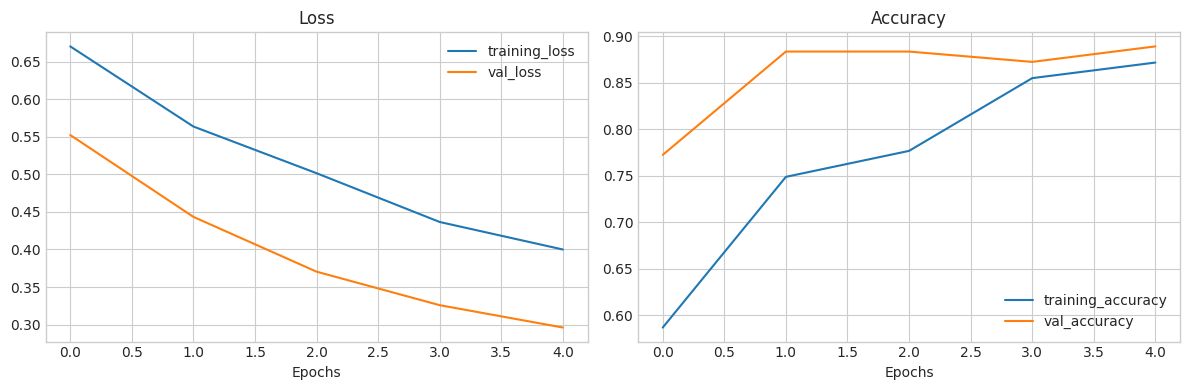

In [28]:
plot_history(base_eff_modelOne_history)

In [29]:
# Test results of the model
results_aug_25 = base_eff_modelOne.evaluate(test_data)
results_aug_25

7/7 [==============================] - 1s 55ms/step - loss: 0.3838 - accuracy: 0.8438


[0.38381442427635193, 0.84375]

In [30]:
# Load the weights from the pre-trained model 
base_eff_modelOne.load_weights(checkpoint_path)
base_loaded_weights = base_eff_modelOne.evaluate(test_data)
base_loaded_weights

7/7 [==============================] - 0s 47ms/step - loss: 0.3838 - accuracy: 0.8438


[0.38381442427635193, 0.84375]

#### 🔨  Fine Tuning

In [31]:
# create a new instance of the base model with lower learning rate
base_eff_modelTwo = create_b0_base(lr = 0.0001)
# Load the weights from the previous model chekpoint
base_eff_modelTwo.load_weights(checkpoint_path)

In [32]:
# Evaluate the test results to make sure they are same
base_eff_modelTwo.evaluate(test_data)

7/7 [==============================] - 3s 56ms/step - loss: 0.3838 - accuracy: 0.8438


[0.3838144838809967, 0.84375]

In [33]:
base_eff_modelTwo.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 5921874 (22.59 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [34]:
print("Total trainable parameters in the model ", len(base_eff_modelTwo.trainable_variables))

Total trainable parameters in the model  2


In [35]:
for _,layer in enumerate(base_eff_modelTwo.layers):
    print("Layer no : ",_,"Trainable : ",layer.trainable, "Layer Name : ", layer.name,)

Layer no :  0 Trainable :  True Layer Name :  input layer
Layer no :  1 Trainable :  False Layer Name :  efficientnetv2-b0
Layer no :  2 Trainable :  True Layer Name :  global_average_pooling2d_2
Layer no :  3 Trainable :  True Layer Name :  dense_2


In [36]:
# Fine tune the EfficientNetB0 layer
base_eff_modelTwo_base = base_eff_modelTwo.layers[1]

In [37]:
base_eff_modelTwo_base.trainable = True
# Freeze all layers except for the last 10
for layer in base_eff_modelTwo_base.layers[:-10]:
    layer.trainable = False

In [38]:
for no,layer in enumerate(base_eff_modelTwo_base.layers):
    print("Layer no : ",no,"Trainable : ",layer.trainable, "Layer Name : ", layer.name,)    

Layer no :  0 Trainable :  False Layer Name :  input_3
Layer no :  1 Trainable :  False Layer Name :  rescaling_2
Layer no :  2 Trainable :  False Layer Name :  normalization_2
Layer no :  3 Trainable :  False Layer Name :  stem_conv
Layer no :  4 Trainable :  False Layer Name :  stem_bn
Layer no :  5 Trainable :  False Layer Name :  stem_activation
Layer no :  6 Trainable :  False Layer Name :  block1a_project_conv
Layer no :  7 Trainable :  False Layer Name :  block1a_project_bn
Layer no :  8 Trainable :  False Layer Name :  block1a_project_activation
Layer no :  9 Trainable :  False Layer Name :  block2a_expand_conv
Layer no :  10 Trainable :  False Layer Name :  block2a_expand_bn
Layer no :  11 Trainable :  False Layer Name :  block2a_expand_activation
Layer no :  12 Trainable :  False Layer Name :  block2a_project_conv
Layer no :  13 Trainable :  False Layer Name :  block2a_project_bn
Layer no :  14 Trainable :  False Layer Name :  block2b_expand_conv
Layer no :  15 Trainable :  F

In [39]:
print("Total trainable parameters in the model ", len(base_eff_modelTwo.trainable_variables))
# Initila 2 + now unfreeing 10 = 12

Total trainable parameters in the model  12


In [40]:
# recompiling the model
base_eff_modelTwo.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics = ['accuracy'])
fine_tune_epochs = initial_epochs + 5
base_eff_modelTwo_history = base_eff_modelTwo.fit(train_data,epochs = fine_tune_epochs,
                                                  steps_per_epoch = len(train_data),
                                                  initial_epoch=base_eff_modelOne_history.epoch[-1],
                                                  validation_data = valid_data,
                                                  validation_steps = len(valid_data))                                                 

Epoch 5/10


2023-12-19 09:55:59.865029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 13s 146ms/step - loss: 0.4500 - accuracy: 0.8101 - val_loss: 0.2598 - val_accuracy: 0.9333
Epoch 6/10
23/23 [==============================] - 2s 69ms/step - loss: 0.3669 - accuracy: 0.8729 - val_loss: 0.2242 - val_accuracy: 0.9389
Epoch 7/10
23/23 [==============================] - 2s 69ms/step - loss: 0.3171 - accuracy: 0.8827 - val_loss: 0.2002 - val_accuracy: 0.9500
Epoch 8/10
23/23 [==============================] - 2s 69ms/step - loss: 0.2887 - accuracy: 0.8966 - val_loss: 0.1863 - val_accuracy: 0.9444
Epoch 9/10
23/23 [==============================] - 2s 70ms/step - loss: 0.2750 - accuracy: 0.9078 - val_loss: 0.1791 - val_accuracy: 0.9444
Epoch 10/10
23/23 [==============================] - 2s 71ms/step - loss: 0.2551 - accuracy: 0.9078 - val_loss: 0.1758 - val_accuracy: 0.9278


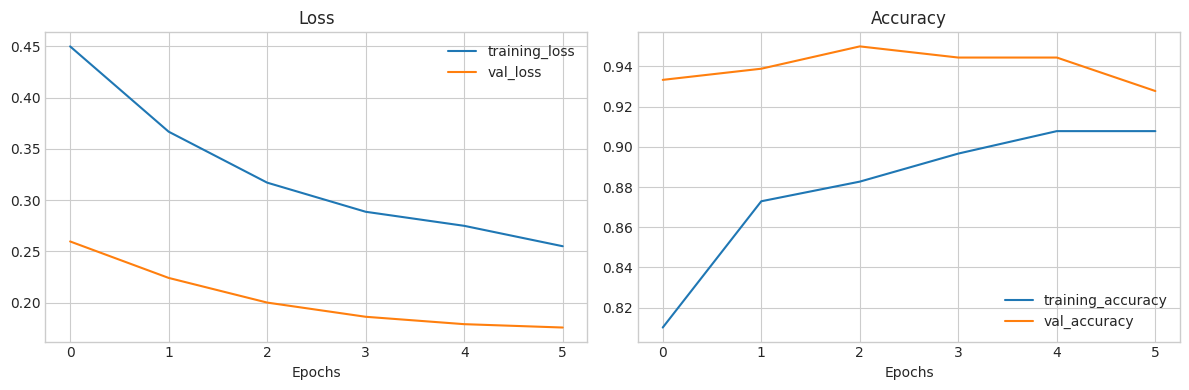

In [41]:
plot_history(base_eff_modelTwo_history)

#### Finding the ideal learning rate with LearningRateScheduler callback**

In [42]:
base_eff_modelTwo.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(),metrics = ['accuracy'])
fine_tune_epochs = initial_epochs + 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
base_eff_modelTwo_history = base_eff_modelTwo.fit(train_data,epochs = fine_tune_epochs,
                                                  steps_per_epoch = len(train_data),
                                                  initial_epoch=base_eff_modelOne_history.epoch[-1],
                                                  validation_data = valid_data,
                                                  validation_steps = len(valid_data),
                                                  callbacks = [lr_scheduler]
                                                 )  

Epoch 5/55


2023-12-19 09:56:25.281748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 13s 149ms/step - loss: 0.2363 - accuracy: 0.9162 - val_loss: 0.1542 - val_accuracy: 0.9444 - lr: 1.5849e-04
Epoch 6/55
23/23 [==============================] - 2s 71ms/step - loss: 0.2047 - accuracy: 0.9288 - val_loss: 0.1491 - val_accuracy: 0.9500 - lr: 1.7783e-04
Epoch 7/55
23/23 [==============================] - 2s 70ms/step - loss: 0.1780 - accuracy: 0.9399 - val_loss: 0.1379 - val_accuracy: 0.9556 - lr: 1.9953e-04
Epoch 8/55
23/23 [==============================] - 2s 71ms/step - loss: 0.1565 - accuracy: 0.9539 - val_loss: 0.1307 - val_accuracy: 0.9500 - lr: 2.2387e-04
Epoch 9/55
23/23 [==============================] - 2s 70ms/step - loss: 0.1342 - accuracy: 0.9679 - val_loss: 0.1223 - val_accuracy: 0.9667 - lr: 2.5119e-04
Epoch 10/55
23/23 [==============================] - 2s 70ms/step - loss: 0.1093 - accuracy: 0.9721 - val_loss: 0.1320 - val_accuracy: 0.9611 - lr: 2.8184e-04
Epoch 11/55
23/23 [==============================] - 2s 70ms

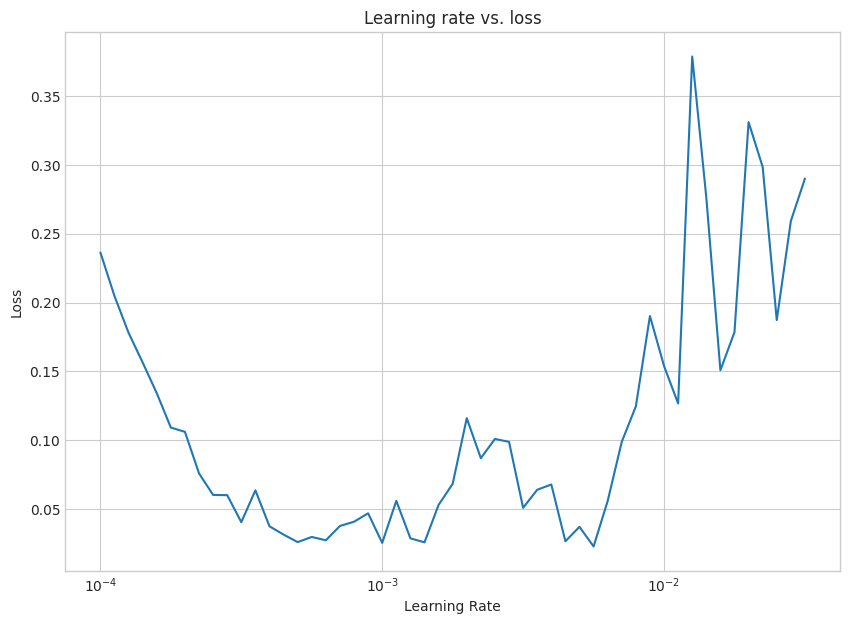

In [43]:
lrs = 1e-4 * (10 ** (np.arange(51)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, base_eff_modelTwo_history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

Picking the best learning rate from the graph

In [44]:
Learning_rate = 1e-2
# recompiling the model with learning reate
base_eff_modelTwo.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = Learning_rate),metrics = ['accuracy'])
fine_tune_epochs = initial_epochs + 5
base_eff_modelThree_history = base_eff_modelTwo.fit(train_data,epochs = fine_tune_epochs,
                                                  steps_per_epoch = len(train_data),
                                                  initial_epoch=base_eff_modelOne_history.epoch[-1],
                                                  validation_data = valid_data,
                                                  validation_steps = len(valid_data))        

Epoch 5/10


2023-12-19 09:58:27.552711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 13s 151ms/step - loss: 0.1452 - accuracy: 0.9707 - val_loss: 0.5742 - val_accuracy: 0.9444
Epoch 6/10
23/23 [==============================] - 2s 70ms/step - loss: 0.0393 - accuracy: 0.9902 - val_loss: 0.6017 - val_accuracy: 0.9389
Epoch 7/10
23/23 [==============================] - 2s 72ms/step - loss: 0.0613 - accuracy: 0.9846 - val_loss: 0.5449 - val_accuracy: 0.9444
Epoch 8/10
23/23 [==============================] - 2s 71ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.4982 - val_accuracy: 0.9444
Epoch 9/10
23/23 [==============================] - 2s 71ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.5819 - val_accuracy: 0.9500
Epoch 10/10
23/23 [==============================] - 2s 70ms/step - loss: 0.0190 - accuracy: 0.9916 - val_loss: 0.6555 - val_accuracy: 0.9500


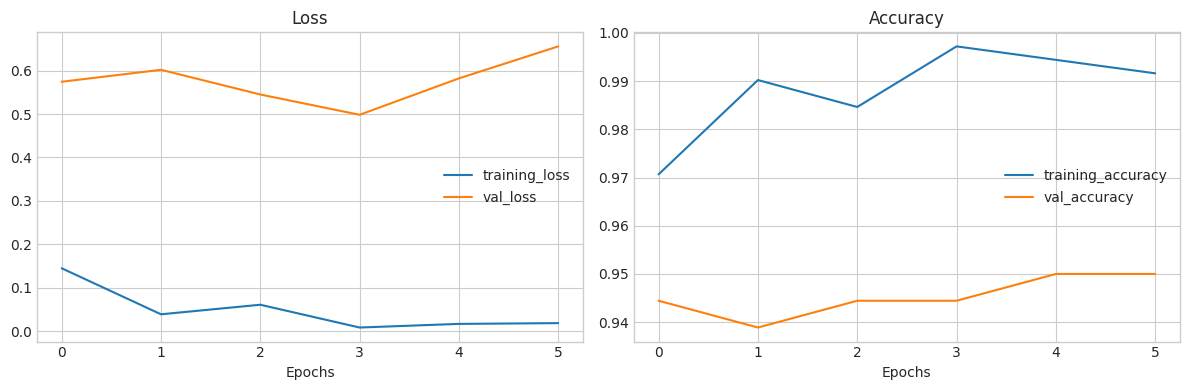

In [45]:
plot_history(base_eff_modelThree_history)

In [46]:
# Accuracy on the test model
base_eff_modelTwo.evaluate(test_data)

7/7 [==============================] - 0s 48ms/step - loss: 0.3143 - accuracy: 0.9286


[0.31429988145828247, 0.9285714030265808]

The accuracy is around 95% on the test data

#### Test the model with a random image from the web

In [47]:
# Create a function to import an image and resize it to be able to be used with our model
from PIL import Image
from io import BytesIO
import requests
def plot_and_predict(url,img_shape = 224):
#     Download and preprocess
    response = requests.get(url)
    image_data = BytesIO(response.content)
    image = Image.open(image_data)
    image = image.convert("RGB")
    image = image.resize((img_shape, img_shape))
    image_array = np.array(image)
    
#     Make predictions
    img = np.expand_dims(image_array, axis=0)
    prediction = base_eff_modelTwo.predict(img,verbose = 0)
    predicted_label = np.argmax(prediction)
    
    print(f"Smoking with probability {prediction[0][1]*100}")
    print(f"Non-Smoking with probability {prediction[0][0]*100}")
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.show

    

Smoking with probability 99.99998807907104
Non-Smoking with probability 5.528732671677972e-06


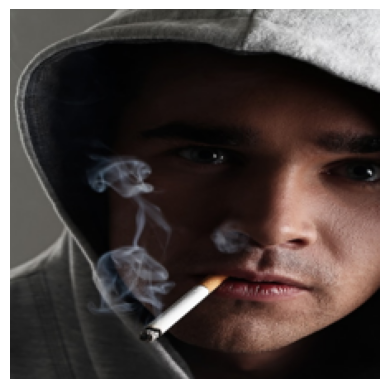

In [48]:
plot_and_predict('https://img.freepik.com/free-photo/young-man-smoking_144627-29295.jpg')

Smoking with probability 99.9998927116394
Non-Smoking with probability 0.00010884052699111635


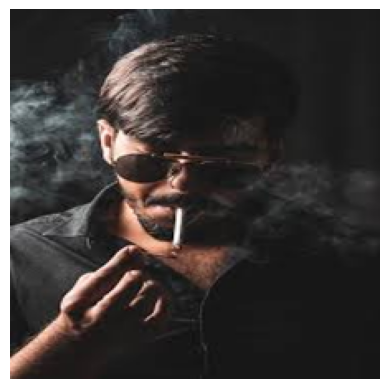

In [49]:
plot_and_predict('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZ2FnaBLHoNCw4OM00db5ahJdvs_LXEo45OQ&usqp=CAU')

Smoking with probability 8.21764184477658e-09
Non-Smoking with probability 100.0


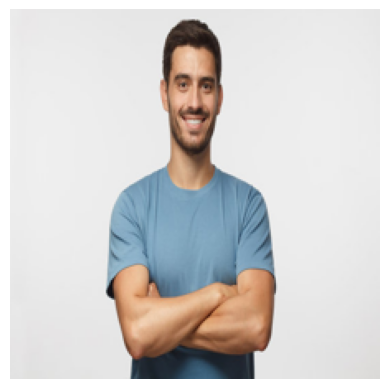

In [50]:
plot_and_predict('https://t4.ftcdn.net/jpg/02/24/86/95/360_F_224869519_aRaeLneqALfPNBzg0xxMZXghtvBXkfIA.jpg')

Smoking with probability 0.01924387615872547
Non-Smoking with probability 99.98108744621277


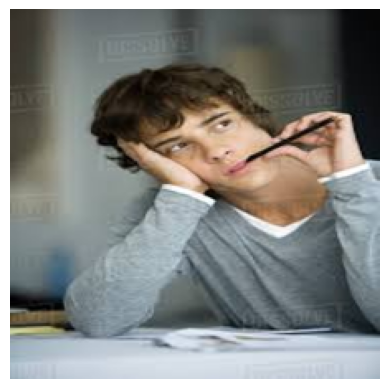

In [51]:
plot_and_predict("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRY7f8d0V9xyQ37QTSgdDhFm6eZ15zdzoxYxw&usqp=CAU")